### AutoEncoder - Based Decision

In [2]:
%autosave 30
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))
from IPython.display import clear_output
import numpy as np
import gc
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import utils_AE_onesubject as fx
from matplotlib.lines import Line2D
import pickle
import importlib as imp
from scipy.signal import welch as pwelch
from sklearn.metrics import confusion_matrix

Autosaving every 30 seconds


### FOR EACH SESSION INDEPENDENTLY

In [ ]:
# =================================== # 
# =================================== # 
# =================================== # 
# DO NOT EXECUTE IF ALREADY COMPUTED (Manasanch: ja esta executat)
# =================================== # 
# =================================== # 
# =================================== # 

imp.reload(fx)
name_times = ['Phoebe 210626', 'Phoebe 210620', 'Phoebe 210725', 'Phoebe 210717', 'Natasha 220107', 'Natasha 211211', 'Monica 210731', 'Monica 210724', 'Skipper 210123']
AE_type = 'enhanced'
for ndx, name_time in enumerate(name_times):
    clear_output()
    print(name_time, ndx+1, '/', len(name_times))
    name = name_time.split(' ')[0]
    time = name_time.split(' ')[1]
    
    # compute
    min_mse_state_and_gt, matches_count, non_matches_count, unsure_count, half_states_count, waveforms_state_2d, autoencoders = fx.get_classification_AE(name_time, AE_type=AE_type)
    
    # read metadata (comes from unknown_autoencoders notebook)
    path = f'C:\\Users\\manasanch.IBP10386\\Desktop\\ANESTHESIA_LEVELS\\DATA\\DATA_LIVEPAPER\\RAW TRANSITIONS\\full_recordings\\autoencoders\\metadata_{name}_{time}_withGT.pkl' 
    with open(path, 'rb') as f:
        metadata=pickle.load(f)
        
    # get the labels of the unknown (those below 90% in the CNN)
    labels_CNN_unknown = [metadata['high_prob_state_label'][i] for i in np.where(metadata['labels'] == 'unknown')[0]]
    
    # reconstruct
    reconstruct = np.array([])
    for i in range(waveforms_state_2d['unknown'].shape[0]):
        if not i % 100:
            print(i)
        
        # get sample
        sample = waveforms_state_2d['unknown'][i].reshape(1, -1)  # Reshape the sample to have shape (1, n_features)
        
        # Use the autoencoders to predict this sample (now we don't care about the AE-predicted but about the CNN label with the highest probability)
        predicted = autoencoders[labels_CNN_unknown[i]].predict(sample, verbose=False)[0] # get the AE decision based ones
        
        # vstack to reconstructed
        reconstruct = np.vstack([reconstruct, predicted]) if reconstruct.size else predicted
    
    # save 
    dict_to_save = {
        'min_mse_state_and_gt': min_mse_state_and_gt, 
        'matches_count': matches_count, 
        'non_matches_count': non_matches_count, 
        'unsure_count': unsure_count, 
        'half_states_count': half_states_count, 
        'waveforms_state_2d': waveforms_state_2d, 
        'autoencoders': autoencoders, 
        'reconstruct': reconstruct}

    with open(f'C:/Users/manasanch.IBP10386/Desktop/ANESTHESIA_LEVELS/DATA/DATA_LIVEPAPER/RAW TRANSITIONS/full_recordings/autoencoders/reconstruct_{AE_type}_{name_time}' , 'wb') as f:
        pickle.dump(dict_to_save, f)
        
    with open(f'C:/Users/manasanch.IBP10386/Desktop/ANESTHESIA_LEVELS/DATA/DATA_LIVEPAPER/RAW TRANSITIONS/full_recordings/autoencoders/reconstruct_{AE_type}_{name_time}' , 'rb') as f:
        info = pickle.load(f)
    clear_output()
    print(name_time)

    min_mse_state_and_gt = info['min_mse_state_and_gt']
    matches_count = info['matches_count']
    non_matches_count = info['non_matches_count']
    unsure_count = info['unsure_count']
    half_states_count = info['half_states_count']
    waveforms_state_2d = info['waveforms_state_2d']
    autoencoders = info['autoencoders']
    reconstruct = info['reconstruct']


    original_GT = np.array([])
    reconstruct_GT = np.array([])
    labels = []
    states_GT = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown']
    for state in states_GT:
        print(state)
        for i in range(waveforms_state_2d[state].shape[0]): # the samples assigned to each state are assigned via the AE classification
            sample = waveforms_state_2d[state][i].reshape(1, -1) # Reshape the sample to have shape (1, n_features)
            # Use the autoencoders to predict this sample
            predicted = autoencoders[state].predict(sample, verbose=False)[0] # get the AE decision based ones
            # vstack to original
            original_GT = np.vstack([original_GT, sample]) if original_GT.size else sample
            # vstack to reconstruct
            reconstruct_GT = np.vstack([reconstruct_GT, predicted]) if reconstruct_GT.size else predicted
        # append label
        labels.extend([state] * waveforms_state_2d[state].shape[0])

    colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 'half-state':'tab:orange', 'unknown': 'tab:brown', 'artifact':'gray'}
    col_GT = [colors[label] for label in labels]
    bands = [[0.1, 4], [4, 8], [100, 500]]
    fxx_reconstruct_GT, pxx_reconstruct_GT = pwelch(x=reconstruct_GT, fs=1000, nfft=1000, nperseg=500, axis=1)

    # build band power
    power_GT = {'reconstruct': np.array([])}
    for bdx, band in enumerate(bands):
        band_power_GT = np.mean(pxx_reconstruct_GT[:, ((fxx_reconstruct_GT>=band[0])&(fxx_reconstruct_GT<band[1]))], axis=1)
        power_GT['reconstruct'] = np.vstack([power_GT['reconstruct'], band_power_GT]) if power_GT['reconstruct'].size else band_power_GT

    # define centroids
    centroids = {}
    # loop over labels
    for label in set(labels):
        # find indices for each state
        indices = np.where(np.array(labels)==label)[0]
        # compute centroid
        centroids[label] = np.array([
            np.mean(np.log(power_GT['reconstruct'][0, indices])), 
            np.mean(np.log(power_GT['reconstruct'][1, indices])), 
            np.mean(np.log(power_GT['reconstruct'][2, indices]))])

    # define intermediate points
    mid_points = {}
    unique_labels = list(set(labels))
    for ldx0 in range(len(unique_labels)-1):
        for ldx1 in range(ldx0+1, len(unique_labels)):
            mid_points[f"{unique_labels[ldx0]}-{unique_labels[ldx1]}"] = [
                (centroids[unique_labels[ldx0]][0] + centroids[unique_labels[ldx1]][0] ) / 2, 
                (centroids[unique_labels[ldx0]][1] + centroids[unique_labels[ldx1]][1] ) / 2, 
                (centroids[unique_labels[ldx0]][2] + centroids[unique_labels[ldx1]][2] ) / 2]

    # save 
    dict_to_save_centroids = {
        'mid_points': mid_points, 
        'original_GT': original_GT, 
        'reconstruct_GT': reconstruct_GT, 
        'labels': labels, 
        'states_GT': states_GT, 
        'bands': bands, 
        'power_GT': power_GT, 
        'centroids': centroids}

    with open(f'C:/Users/manasanch.IBP10386/Desktop/ANESTHESIA_LEVELS/DATA/DATA_LIVEPAPER/RAW TRANSITIONS/full_recordings/autoencoders/centroids_plus_reconst_unknowns_{AE_type}_{name_time}' , 'wb') as f:
        pickle.dump(dict_to_save_centroids, f)

### Load the data

In [86]:
# =================================== # 
# =================================== # 
# =================================== # 
# CHANGE THE PATH
# CHANGE THE SESSION TO ANALYSE
# =================================== # 
# =================================== # 
# =================================== # 

## Load subject
name_time = 'Phoebe 210626' # 'Phoebe 210626', 'Phoebe 210620', 'Phoebe 210725', 'Phoebe 210717', 'Natasha 220107', 'Natasha 211211', 'Monica 210731', 'Monica 210724', 'Skipper 210123'
# choose which AE to use, either simple or enhanced
AE_type = 'enhanced' # 'simple', 'enhanced'
# change path
path_AE = 'C:/Users/manasanch.IBP10386/Desktop/ANESTHESIA_LEVELS/DATA/DATA_LIVEPAPER/RAW TRANSITIONS/full_recordings/autoencoders/'

if AE_type == 'simple':
    with open(path_AE + f'reconstruct_{name_time}' , 'rb') as f:
        info = pickle.load(f)
else:
    with open(path_AE + f'reconstruct_{AE_type}_{name_time}' , 'rb') as f:
        info = pickle.load(f)

min_mse_state_and_gt = info['min_mse_state_and_gt']
matches_count = info['matches_count']
non_matches_count = info['non_matches_count']
unsure_count = info['unsure_count']
half_states_count = info['half_states_count']
waveforms_state_2d = info['waveforms_state_2d'] # all waveforms, dict with keys for each state
autoencoders = info['autoencoders'] # each state AE
reconstruct = info['reconstruct'] # reconstructed unknowns with the highest. prob CNN label

if AE_type == 'simple':
    with open(path_AE + f'centroids_plus_reconst_unknowns_{name_time}' , 'rb') as f:
        info2 = pickle.load(f) 
else:
    with open(path_AE + f'centroids_plus_reconst_unknowns_{AE_type}_{name_time}' , 'rb') as f:
        info2 = pickle.load(f) 

mid_points = info2['mid_points'] 
original_GT = info2['original_GT'] 
reconstruct_GT = info2['reconstruct_GT'] 
labels = info2['labels'] 
states_GT = info2['states_GT'] 
bands = info2['bands']
power_GT = info2['power_GT'] # psd power for the CNN samples predicted with > 90% 
centroids = info2['centroids'] # centroid positions for each state

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-11-23 15:44:58         4746
metadata.json                                  2023-11-23 15:44:58           64
variables.h5                                   2023-11-23 15:44:58     13335780
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dense_4
......vars
.........0
.........1
...layers\dense_5
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
..

### Compute accuracy using the centroid-method 

<IPython.core.display.Javascript object>


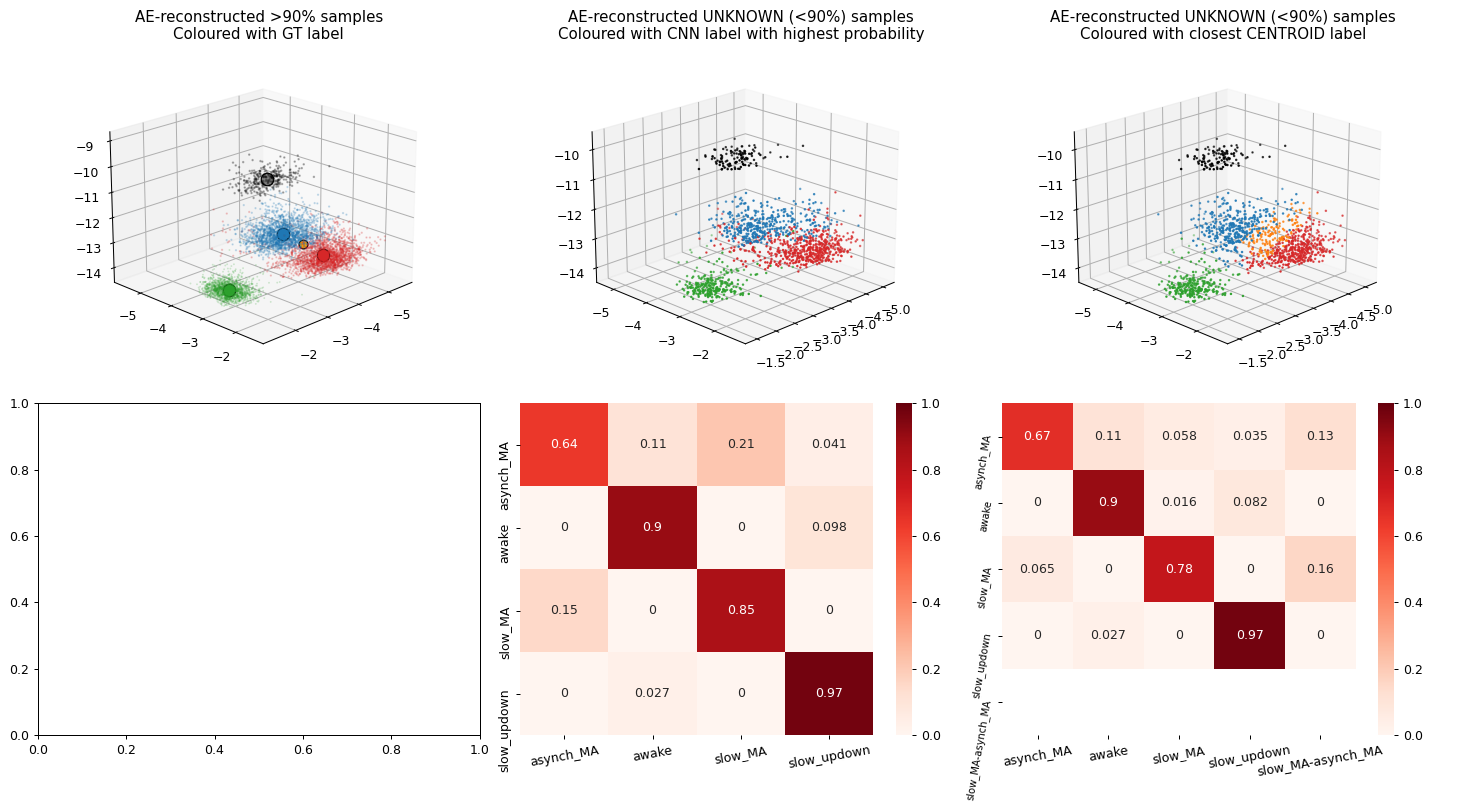

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide


In [287]:
%matplotlib notebook
colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 
          'unknown': 'tab:brown', 'artifact':'gray', 'asynch_MA-slow_MA': 'tab:orange', 'slow_MA-asynch_MA': 'tab:orange'}
# plot scatters
fig = plt.figure(figsize=(18, 10))
ax = [fig.add_subplot(231, projection='3d'), fig.add_subplot(232, projection='3d'), fig.add_subplot(233, projection='3d'), 
      fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)]

# =========== GT (colors) from CNN labelled samples (>90%) scatter ===========
path = f'autoencoders/metadata_{"_".join(name_time.split(" "))}_withGT.pkl'
with open(path, 'rb') as f:
    metadata=pickle.load(f)
    metadata_unknown = metadata.loc[metadata['labels']=='unknown']

# define arrays of labels for gt and predicted
colors_GT = [colors[label] for label in labels]

# scatter
for label in set(labels):
    ldx = np.where(np.array(labels)==label)[0]
    if label == 'slow_updown':
        ax[0].scatter(np.log(power_GT['reconstruct'][0, ldx][::3]), np.log(power_GT['reconstruct'][1, ldx][::3]), np.log(power_GT['reconstruct'][2, ldx][::3]), c=colors[label], s=1, marker='.', alpha=0.2)
    elif label == 'awake':
        ax[0].scatter(np.log(power_GT['reconstruct'][0, ldx]), np.log(power_GT['reconstruct'][1, ldx]), np.log(power_GT['reconstruct'][2, ldx]), c=colors[label], s=1, alpha=0.25)
    else:
        ax[0].scatter(np.log(power_GT['reconstruct'][0, ldx]), np.log(power_GT['reconstruct'][1, ldx]), np.log(power_GT['reconstruct'][2, ldx]), c=colors[label], s=3, marker='.', alpha=0.2)

# add centroids 
for label in set(labels):
    ax[0].scatter(centroids[label][0], centroids[label][1], centroids[label][2], edgecolor='k', marker='o', s=100, c=colors[label] if label != 'awake' else 'gray')

# add mid points
unique_labels = list(set(labels))
for ldx0 in range(len(unique_labels)-1):
    for ldx1 in range(ldx0+1, len(unique_labels)):
        if f"{unique_labels[ldx0]}-{unique_labels[ldx1]}" in mid_points:
            comb = f"{unique_labels[ldx0]}-{unique_labels[ldx1]}"
        else:
            comb = f"{unique_labels[ldx1]}-{unique_labels[ldx0]}"
        # only add the asynch_MA-slow_MA transition
        if comb == 'asynch_MA-slow_MA' or comb == 'slow_MA-asynch_MA':
            ax[0].scatter(mid_points[comb][0],
                          mid_points[comb][1],
                          mid_points[comb][2], marker='o', s=50, edgecolor='k', c='orange')

labels_GT = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown']
ax[0].set_title('AE-reconstructed > 90% samples\nColoured with GT label')
    
# =========== UNKNOWN scatter with COLOR of AE used ===========
bands = [[0.1, 4], [4, 8], [100, 500]]
fxx_original, pxx_original = pwelch(x=waveforms_state_2d['unknown'], fs=1000, nfft=1000, nperseg=500, axis=1)
fxx_reconstruct, pxx_reconstruct = pwelch(x=reconstruct, fs=1000, nfft=1000, nperseg=500, axis=1)

# build band power
power = {'original': np.array([]), 'reconstruct': np.array([])}
for bdx, band in enumerate(bands):
    band_power = np.mean(pxx_original[:, ((fxx_original>=band[0])&(fxx_original<band[1]))], axis=1)
    power['original'] = np.vstack([power['original'], band_power]) if power['original'].size else band_power
    band_power = np.mean(pxx_reconstruct[:, ((fxx_reconstruct>=band[0])&(fxx_reconstruct<band[1]))], axis=1)
    power['reconstruct'] = np.vstack([power['reconstruct'], band_power]) if power['reconstruct'].size else band_power
    
# scatter
# define arrays of labels for gt and predicted
colors_unknownAE = [colors[label] for label in metadata_unknown['high_prob_state_label']]
ax[1].scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=colors_unknownAE, s=1)
ax[1].set_title('AE-reconstructed UNKNOWN (<90%) samples\nColoured with CNN label with highest probability')

# define arrays of labels for gt and predicted
y_true = metadata_unknown['GT']
y_pred = metadata_unknown['high_prob_state_label']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_GT)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap
sns.heatmap(cm_normalized, annot=True, cmap="Reds", xticklabels=labels_GT, yticklabels=labels_GT, ax=ax[4], vmin=0, vmax=1)
ax[4].set_xticklabels(labels_GT, rotation=10)

# =========== UNKNOWN scatter with COLOR of CENTROID CLASSIFICATION ===========
# classify on centroids
centroid_points = np.array([])
centroid_labels =  []
for centroid_label, point in mid_points.items():
    centroid_points = np.vstack([centroid_points, np.array(point)]) if centroid_points.size else np.array(point)
    centroid_labels.append(centroid_label)
for centroid_label, point in centroids.items():
    centroid_points = np.vstack([centroid_points, np.array(point)]) 
    centroid_labels.append(centroid_label)

# classify all unknowns again based on centroids
labels_centroid_based = []
for i in range(power['reconstruct'].shape[1]):
    labels_centroid_based.append(fx.find_closest_centroid(np.log(power['reconstruct'][:, i]), centroid_points, centroid_labels))

colors_unknowncentroid = [colors[label] for label in labels_centroid_based]
ax[2].scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=colors_unknowncentroid, s=1)

labels_centroid_CM = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown', 'slow_MA-asynch_MA']

# define arrays of labels for gt and predicted
y_true = metadata_unknown['GT']
y_pred = labels_centroid_based

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_centroid_CM)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap
sns.heatmap(cm_normalized, annot=True, cmap="Reds", xticklabels=labels_centroid_CM, yticklabels=labels_centroid_CM, ax=ax[5], vmin=0, vmax=1)
ax[5].set_xticklabels(labels_centroid_CM, rotation=10)
ax[5].set_yticklabels(labels_centroid_CM, rotation=80 ,fontsize=8)
ax[2].set_title('AE-reconstructed UNKNOWN (<90%) samples\nColoured with closest CENTROID label')
ax[0].view_init(elev=20, azim=45)
ax[1].view_init(elev=20, azim=45)
ax[2].view_init(elev=20, azim=45)
plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\clusters_after_centroids.svg', dpi=600)

## Figure transitions

<IPython.core.display.Javascript object>


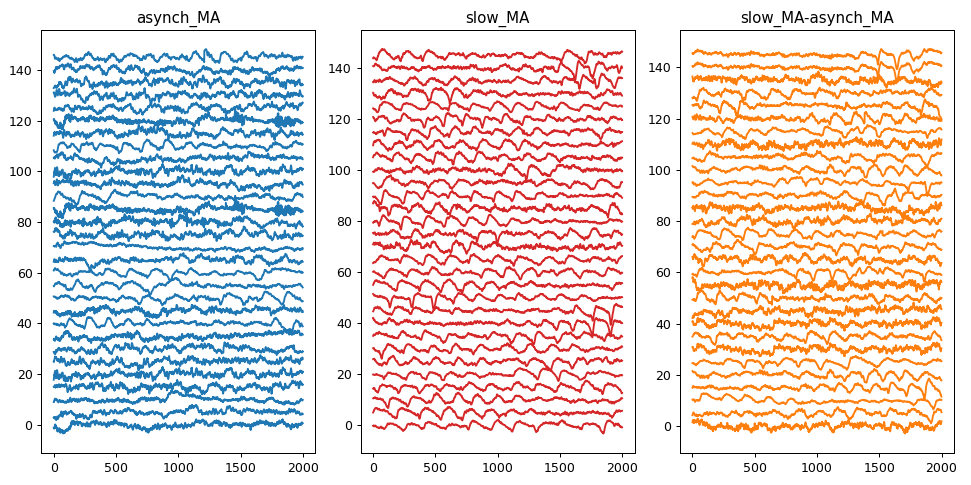

[ 792  797  549  515  734  794  659  788 1299  550  946  949  867  538
  743  536  707  703  398  580  734  462 1196  535  703  513  451  519
  643  406]
[ 850  974 1234  822  939  927  979 1106 1297 1283 1286  974 1042  969
  470 1016 1314 1207 1313  958  402 1218  991 1156 1145  907 1053 1028
 1265  928]
[ 622  920 1076 1192  865  962  708 1094  708  760 1248  600 1169  497
  400 1075  540  793  813  845  865  390  700  825  419 1316  922  625
 1272  130]


In [288]:
%matplotlib notebook
n_traces = 30
transitions = ['asynch_MA', 'slow_MA', 'slow_MA-asynch_MA']
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 6))
for i, state in enumerate(transitions):
    # do random selection of indices belonging to that state
    tdxs = np.random.choice(np.where(np.array(labels_centroid_based)==state)[0], n_traces)
    print(tdxs)
    for h, tdx in enumerate(tdxs):
        ax[i].plot(5*h + waveforms_state_2d['unknown'][tdx, :], c=colors[state])
    ax[i].set_title(state)
plt.tight_layout()

## Compute accuracy of CNN and compare with centroid-based

In [201]:
%matplotlib notebook
# define sessions to be included
name_times = ['Phoebe 210626', 'Phoebe 210620', 'Phoebe 210725', 'Phoebe 210717', 'Natasha 220107', 'Natasha 211211', 'Monica 210731', 'Monica 210724', 'Skipper 210123']
df_accuracies = pd.DataFrame(columns=['name_time', 'state', 'acc', 'type_classification'])
trans_perc = {}
AE_type = 'enhanced' # 'simple', 'enhanced'

for ndx, name_time in enumerate(name_times):
    
    ## general accuracy, no confidence threshold, no transitions
    ## ====== CNN ======
    path = f'autoencoders/metadata_{"_".join(name_time.split(" "))}_withGT.pkl'
    with open(path, 'rb') as f:
        metadata=pickle.load(f)
    labels = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown']
    # define arrays of labels for gt and predicted
    y_true = metadata['GT']
    y_pred = metadata['high_prob_state_label']
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for ldx, label in enumerate(labels): 
        df_accuracies = pd.concat([df_accuracies, 
                                  pd.DataFrame({
                                      'name_time': name_time, 
                                      'state': label, 
                                      'acc': [cm_normalized[ldx, ldx]], 
                                      'type_classification': 'Global',
                                  })], ignore_index=True)
    
    
    ## ====== CNN ======
    path = f'autoencoders/metadata_{"_".join(name_time.split(" "))}_withGT.pkl'
    with open(path, 'rb') as f:
        metadata=pickle.load(f)
    labels = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown']
    # find indices of unknowns
    udx = np.where(metadata['labels']=='unknown')[0]
    # define arrays of labels for gt and predicted
    y_true = metadata['GT'][udx]
    y_pred = metadata['high_prob_state_label'][udx]
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for ldx, label in enumerate(labels): 
        df_accuracies = pd.concat([df_accuracies, 
                                  pd.DataFrame({
                                      'name_time': name_time, 
                                      'state': label, 
                                      'acc': [cm_normalized[ldx, ldx]], 
                                      'type_classification': 'CNN',
                                  })], ignore_index=True)
    
    ## ====== CENTROID ======
    if AE_type == 'simple':
        with open(path_AE + f'reconstruct_{name_time}' , 'rb') as f:
            info = pickle.load(f)
    else:
        with open(path_AE + f'reconstruct_{AE_type}_{name_time}' , 'rb') as f:
            info = pickle.load(f)

    min_mse_state_and_gt = info['min_mse_state_and_gt']
    matches_count = info['matches_count']
    non_matches_count = info['non_matches_count']
    unsure_count = info['unsure_count']
    half_states_count = info['half_states_count']
    waveforms_state_2d = info['waveforms_state_2d'] # all waveforms, dict with keys for each state
    autoencoders = info['autoencoders'] # each state AE
    reconstruct = info['reconstruct'] # reconstructed unknowns with the highest. prob CNN label

    if AE_type == 'simple':
        with open(path_AE + f'centroids_plus_reconst_unknowns_{name_time}' , 'rb') as f:
            info2 = pickle.load(f) 
    else:
        with open(path_AE + f'centroids_plus_reconst_unknowns_{AE_type}_{name_time}' , 'rb') as f:
            info2 = pickle.load(f) 

    mid_points = info2['mid_points'] 
    original_GT = info2['original_GT'] 
    reconstruct_GT = info2['reconstruct_GT'] 
    labels = info2['labels'] 
    states_GT = info2['states_GT'] 
    bands = info2['bands']
    power_GT = info2['power_GT'] # psd power for the CNN samples predicted with > 90% 
    centroids = info2['centroids'] # centroid positions for each state
    
    # get metadata unknown
    metadata_unknown = metadata.loc[metadata['labels']=='unknown']

    # =========== UNKNOWN scatter with COLOR of AE used ===========
    bands = [[0.1, 4], [4, 8], [100, 500]]
    fxx_original, pxx_original = pwelch(x=waveforms_state_2d['unknown'], fs=1000, nfft=1000, nperseg=500, axis=1)
    fxx_reconstruct, pxx_reconstruct = pwelch(x=reconstruct, fs=1000, nfft=1000, nperseg=500, axis=1)

    # build band power
    power = {'original': np.array([]), 'reconstruct': np.array([])}
    for bdx, band in enumerate(bands):
        band_power = np.mean(pxx_original[:, ((fxx_original>=band[0])&(fxx_original<band[1]))], axis=1)
        power['original'] = np.vstack([power['original'], band_power]) if power['original'].size else band_power
        band_power = np.mean(pxx_reconstruct[:, ((fxx_reconstruct>=band[0])&(fxx_reconstruct<band[1]))], axis=1)
        power['reconstruct'] = np.vstack([power['reconstruct'], band_power]) if power['reconstruct'].size else band_power


    # =========== UNKNOWN scatter with COLOR of CENTROID CLASSIFICATION ===========
    # classify on centroids
    centroid_points = np.array([])
    centroid_labels =  []
    for centroid_label, point in mid_points.items():
        centroid_points = np.vstack([centroid_points, np.array(point)]) if centroid_points.size else np.array(point)
        centroid_labels.append(centroid_label)
    for centroid_label, point in centroids.items():
        centroid_points = np.vstack([centroid_points, np.array(point)]) 
        centroid_labels.append(centroid_label)

    # classify all unknowns again based on centroids
    labels_centroid_based = []
    for i in range(power['reconstruct'].shape[1]):
        labels_centroid_based.append(fx.find_closest_centroid(np.log(power['reconstruct'][:, i]), centroid_points, centroid_labels))

    
    labels_centroid_CM = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown', 'slow_MA-asynch_MA']
    # define arrays of labels for gt and predicted
    y_true = metadata_unknown['GT']
    y_pred = labels_centroid_based
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels_centroid_CM)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    for ldx, label in enumerate(labels_centroid_CM): 
        if '-' not in label:
            df_accuracies = pd.concat([df_accuracies, 
                                      pd.DataFrame({
                                          'name_time': name_time, 
                                          'state': label, 
                                          'acc': [cm_normalized[ldx, ldx]], 
                                          'type_classification': 'centroid',
                                      })], ignore_index=True)
    trans_perc[name_time] = {'len_unknowns': len(labels_centroid_based), 'len_transitions': len(np.where(np.array(labels_centroid_based)=='slow_MA-asynch_MA')[0])}
    
clear_output()

### Figure accuracies CNN vs centroid

<IPython.core.display.Javascript object>


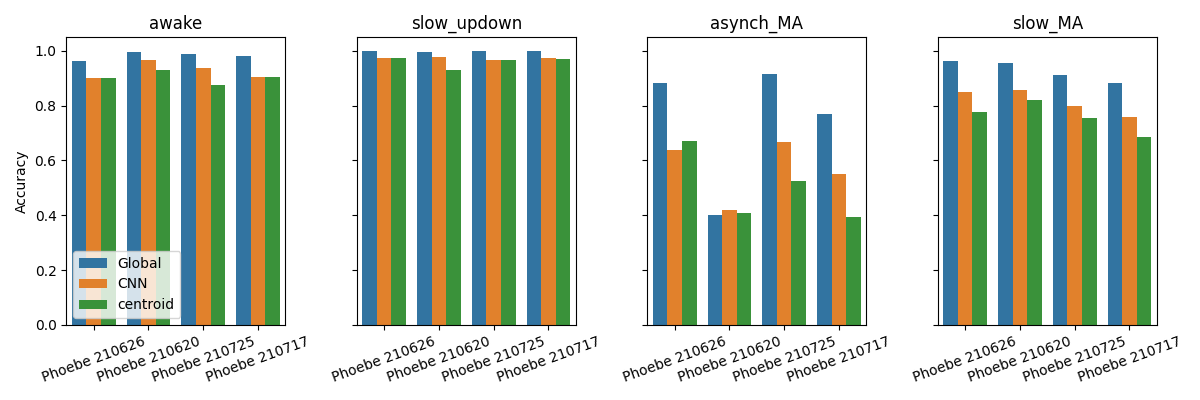

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4), sharey=True)
ax = ax.reshape(-1)
# for ndx, name_time in enumerate(name_times):
#     sns.barplot(data=df_accuracies.loc[df_accuracies['name_time'] == name_time], x='state', y='acc', hue='type_classification', ax=ax[ndx])
df_sub = df_accuracies[df_accuracies['name_time'].str.startswith('Phoebe')]
for ldx, label in enumerate(['awake', 'slow_updown', 'asynch_MA', 'slow_MA']):
    sns.barplot(data=df_sub.loc[df_sub['state'] == label], x='name_time', y='acc', hue='type_classification', ax=ax[ldx])
    ax[ldx].set_title(label)
    ax[ldx].set_xticklabels(ax[ldx].get_xticklabels(), rotation=20)
[ax[ldx].set_xlabel('') for ldx in range(4)]
[ax[ldx].set_ylabel('') for ldx in range(4)]
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc=3)
[ax[ldx+1].legend().set_visible(False) for ldx in range(3)]
plt.tight_layout()

<IPython.core.display.Javascript object>


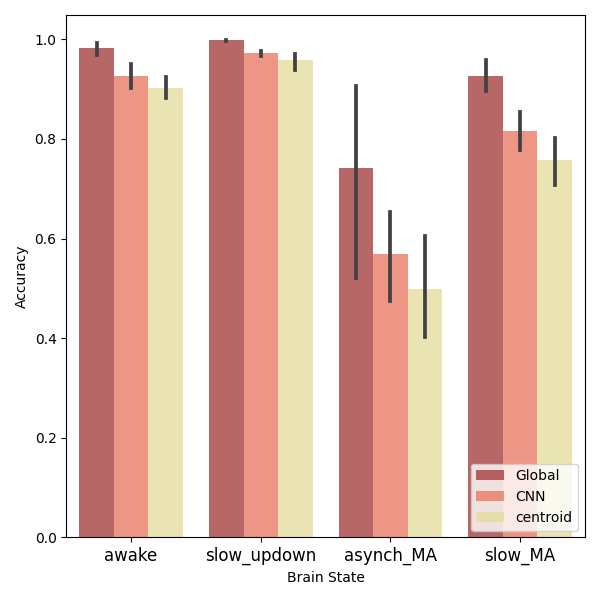

In [204]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
df_sub = df_accuracies[df_accuracies['name_time'].str.startswith('Phoebe')]
sns.barplot(data=df_sub, x='state', y='acc', hue='type_classification', 
            order=['awake', 'slow_updown', 'asynch_MA', 'slow_MA'], 
            palette={'Global': 'firebrick', 'CNN':'tomato', 'centroid': 'khaki'}, alpha=0.75, ax=ax)
ax.legend(loc=4)
ax.set_xlabel('Brain State')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\accuracy_after_centroids.svg', dpi=600)

### Figure transitions

<IPython.core.display.Javascript object>


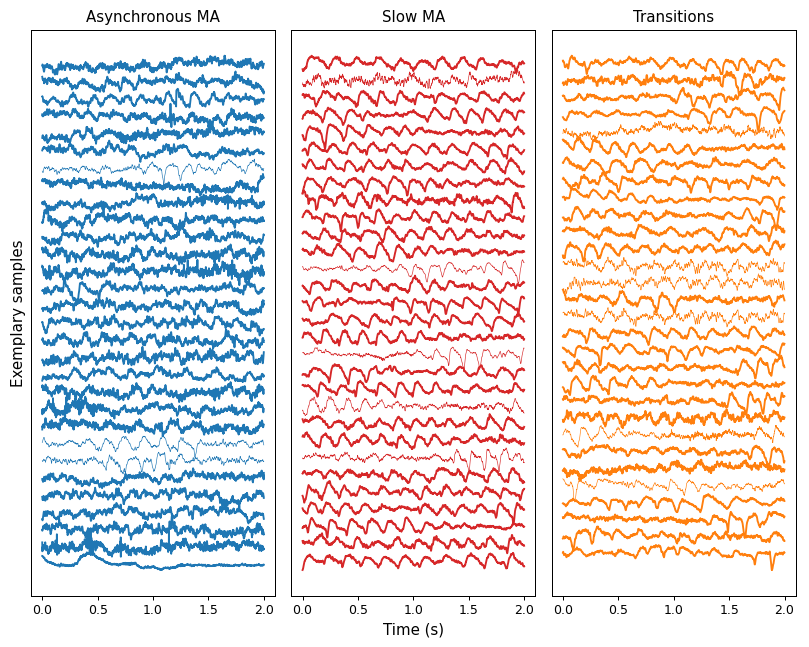

In [99]:
%matplotlib notebook
transitions_total = {
    'Phoebe 210626': {''}
}
n_traces = 30
transitions = ['asynch_MA', 'slow_MA', 'slow_MA-asynch_MA']
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 8))
for i, state in enumerate(transitions):
    # do random selection of indices belonging to that state
    tdxs = np.random.choice(np.where(np.array(labels_centroid_based)==state)[0], n_traces)
    if state=='asynch_MA':
        tdxs = [694,716,648,511,446,479,421,1159,667,710,639,585,450,679,414,722,416,706,639,587,578,702,783,855,488,775,558,406,778,782]
        linewidths = [1.5 if i not in [23, 7, 6] else 0.5 for i in range(30) ]
    elif state == 'slow_MA': 
        tdxs = [943,903,1314,1177,1066,1115,1290,1227,996,1266,1168,872,1285,1179,929,1257,1081,1271,847,978,1157,1207,942,859,899,1264,931,909,712,917]
        linewidths = [1.5 if i not in [28, 17, 12, 9, 6] else 0.5 for i in range(30) ]
    else:
        tdxs = [845,1119,130,962,1282,551,1070,1274,454,1038,1080,992,932,1027,729,1129,432,729,1195,799,1084,1076,400,801,1270,652,808,1020,405,1127]
        linewidths = [1.5 if i not in [25, 17, 16, 14, 7, 4] else 0.5 for i in range(30) ]
        
    for h, tdx in enumerate(tdxs):
        ax[i].plot(np.arange(2000)/1000, 5*h + waveforms_state_2d['unknown'][tdx, :], c=colors[state], linewidth=linewidths[h])
    ax[i].set_title(state)
    ax[i].set_xlabel('')
    ax[i].set_yticks([])
ax[1].set_xlabel('Time (s)', fontsize=12)
ax[0].set_ylabel('Exemplary samples', fontsize=12)
ax[0].set_title('Asynchronous MA', fontsize=12)
ax[1].set_title('Slow MA', fontsize=12)
ax[2].set_title('Transitions', fontsize=12)

plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\traces_transitions.svg', dpi=600)

## Fig. transitions Panel Clusters 

<IPython.core.display.Javascript object>


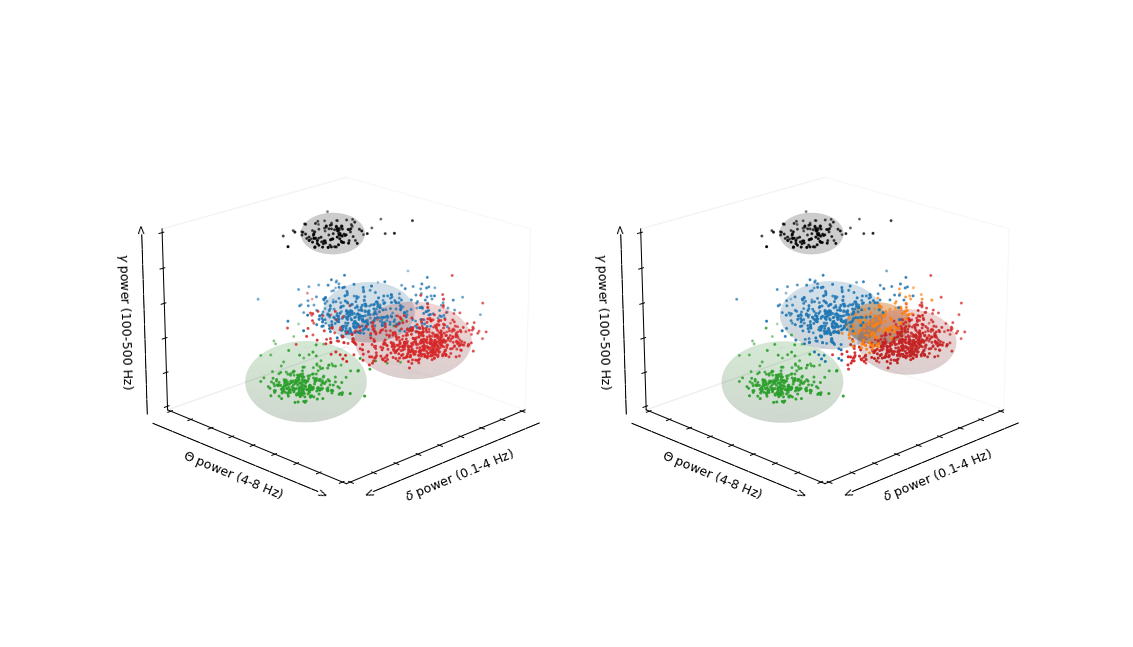

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [155]:
%matplotlib notebook
colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 
          'unknown': 'tab:brown', 'artifact':'gray', 'asynch_MA-slow_MA': 'tab:orange', 'slow_MA-asynch_MA': 'tab:orange'}
# plot scatters
fig = plt.figure(figsize=(14, 8))
ax = [fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')]

# =========== GT (colors) from CNN labelled samples (>90%) scatter ===========
path = f'autoencoders/metadata_{"_".join(name_time.split(" "))}_withGT.pkl'
with open(path, 'rb') as f:
    metadata=pickle.load(f)
    metadata_unknown = metadata.loc[metadata['labels']=='unknown']


# define arrays of labels for gt and predicted
colors_GT = [colors[label] for label in labels]

# =========== UNKNOWN scatter with COLOR of AE used ===========
bands = [[0.1, 4], [4, 8], [100, 500]]
fxx_original, pxx_original = pwelch(x=waveforms_state_2d['unknown'], fs=1000, nfft=1000, nperseg=500, axis=1)
fxx_reconstruct, pxx_reconstruct = pwelch(x=reconstruct, fs=1000, nfft=1000, nperseg=500, axis=1)

# build band power
power = {'original': np.array([]), 'reconstruct': np.array([])}
for bdx, band in enumerate(bands):
    band_power = np.mean(pxx_original[:, ((fxx_original>=band[0])&(fxx_original<band[1]))], axis=1)
    power['original'] = np.vstack([power['original'], band_power]) if power['original'].size else band_power
    band_power = np.mean(pxx_reconstruct[:, ((fxx_reconstruct>=band[0])&(fxx_reconstruct<band[1]))], axis=1)
    power['reconstruct'] = np.vstack([power['reconstruct'], band_power]) if power['reconstruct'].size else band_power
    
####  first scatter plot, no transitions detected ####
colors_unknownAE = [colors[label] for label in metadata_unknown['high_prob_state_label']]
for color in set(colors_unknownAE):
    
    # find indices
    cdxs = np.where(np.array(colors_unknownAE) == color)[0]
    
    # scatter points
    ax[0].scatter(np.log(power['reconstruct'][0, cdxs]), np.log(power['reconstruct'][1, cdxs]), np.log(power['reconstruct'][2, cdxs]), c=color, s=2)
    
    x = np.log(power['reconstruct'][0, cdxs])
    y = np.log(power['reconstruct'][1, cdxs])
    z = np.log(power['reconstruct'][2, cdxs])

    # Calculate the center and radius for the sphere
    center = np.array([np.mean(x), np.mean(y), np.mean(z)])
    radius = 0.35*np.max(np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2))
    
    # Create a sphere
    phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
    x_sphere = center[0] + radius * np.sin(theta) * np.cos(phi)
    y_sphere = center[1] + radius * np.sin(theta) * np.sin(phi)
    z_sphere = center[2] + radius * np.cos(theta)

    # Plot the sphere with transparency
    ax[0].plot_surface(x_sphere, y_sphere, z_sphere, color=color, alpha=0.1)


# =========== UNKNOWN scatter with COLOR of CENTROID CLASSIFICATION ===========
# classify on centroids
centroid_points = np.array([])
centroid_labels =  []
for centroid_label, point in mid_points.items():
    centroid_points = np.vstack([centroid_points, np.array(point)]) if centroid_points.size else np.array(point)
    centroid_labels.append(centroid_label)
for centroid_label, point in centroids.items():
    centroid_points = np.vstack([centroid_points, np.array(point)]) 
    centroid_labels.append(centroid_label)

# classify all unknowns again based on centroids
labels_centroid_based = []
for i in range(power['reconstruct'].shape[1]):
    labels_centroid_based.append(fx.find_closest_centroid(np.log(power['reconstruct'][:, i]), centroid_points, centroid_labels))

colors_unknowncentroid = [colors[label] for label in labels_centroid_based]
for color in set(colors_unknowncentroid):
    
    # find indices
    cdxs = np.where(np.array(colors_unknowncentroid) == color)[0]
    
    # scatter points
    ax[1].scatter(np.log(power['reconstruct'][0, cdxs]), np.log(power['reconstruct'][1, cdxs]), np.log(power['reconstruct'][2, cdxs]), c=color, s=2)
    
    x = np.log(power['reconstruct'][0, cdxs])
    y = np.log(power['reconstruct'][1, cdxs])
    z = np.log(power['reconstruct'][2, cdxs])

    # Calculate the center and radius for the sphere
    center = np.array([np.mean(x), np.mean(y), np.mean(z)])
    radius = 0.35*np.max(np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2))
    
    # Create a sphere
    phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
    x_sphere = center[0] + radius * np.sin(theta) * np.cos(phi)
    y_sphere = center[1] + radius * np.sin(theta) * np.sin(phi)
    z_sphere = center[2] + radius * np.cos(theta)

    # Plot the sphere with transparency
    ax[1].plot_surface(x_sphere, y_sphere, z_sphere, color=color, alpha=0.25 if color=='tab:orange' else 0.1)

    
ax[0].view_init(elev=20, azim=45)
ax[1].view_init(elev=20, azim=45)
# Remove the gray background and grid lines
ax[0].xaxis.pane.fill = False
ax[0].yaxis.pane.fill = False
ax[0].zaxis.pane.fill = False
ax[0].grid(False)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
ax[0].set_xlim([-5, -1])
ax[0].set_ylim([-5, -1])
ax[0].set_zlim([-15, -10])
ax[1].set_xlim([-5, -1])
ax[1].set_ylim([-5, -1])
ax[1].set_zlim([-15, -10])
ax[1].grid(False)
ax[1].xaxis.pane.fill = False
ax[1].yaxis.pane.fill = False
ax[1].zaxis.pane.fill = False
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_zticklabels([])
ax[0].set_xlabel('<────────────────────────\n$\delta$ power (0.1-4 Hz)', labelpad=-6)
ax[0].set_ylabel('────────────────────────>\n$\Theta$ power (4-8 Hz)', labelpad=-6)
ax[0].set_zlabel('<────────────────────────\n$\gamma$ power (100-500 Hz)', labelpad=-6)
ax[1].set_xlabel('<────────────────────────\n$\delta$ power (0.1-4 Hz)', labelpad=-6)
ax[1].set_ylabel('────────────────────────>\n$\Theta$ power (4-8 Hz)', labelpad=-6)
ax[1].set_zlabel('<────────────────────────\n$\gamma$ power (100-500 Hz)', labelpad=-6)
plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\clusters_paper.svg', dpi=600)

### Figure euclidean distance to centroids

In [221]:
df_dist = pd.DataFrame(columns=['gt', 'centroid', 'distance']) 

for i in range(power['reconstruct'].shape[1]):
    for cdx, centroid in enumerate(centroid_points):
        if centroid_labels[cdx] in ['slow_updown', 'asynch_MA', 'awake', 'slow_MA', 'asynch_MA-slow_MA', 'slow_MA-asynch_MA']:
            # compute euclidean distance
            dist = np.linalg.norm(centroid - np.log(power['reconstruct'][:, i]))
            df_dist = pd.concat([df_dist, pd.DataFrame({'gt': labels_centroid_based[i], 'centroid': centroid_labels[cdx], 'distance':[dist]})], ignore_index=True)

<IPython.core.display.Javascript object>


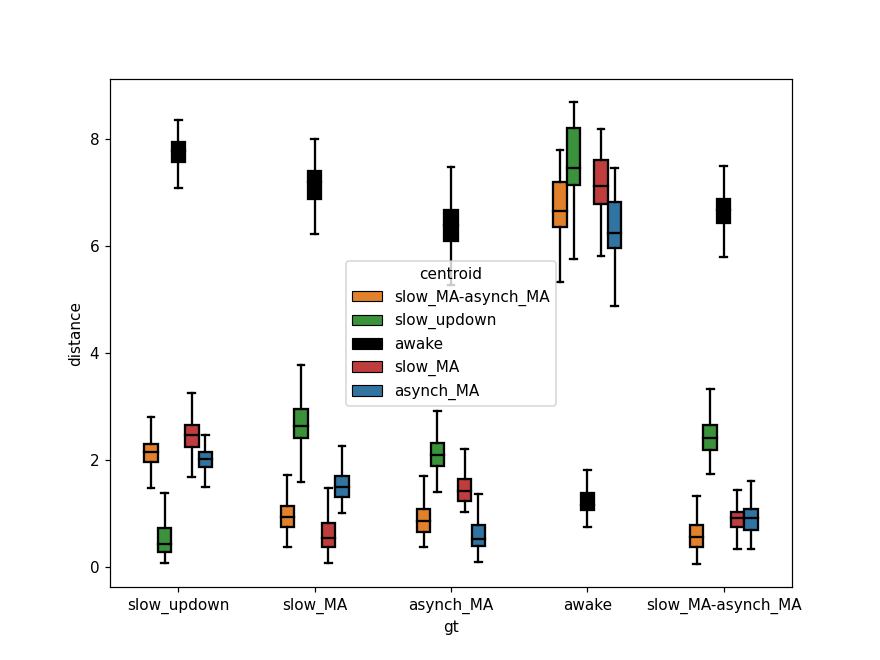

<AxesSubplot:xlabel='gt', ylabel='distance'>

In [236]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_dist, x='gt', y='distance', hue='centroid', width=0.5, ax=ax, showfliers=False, palette=colors)

## Compute accuracy of unknowns (samples < 90%)

<IPython.core.display.Javascript object>


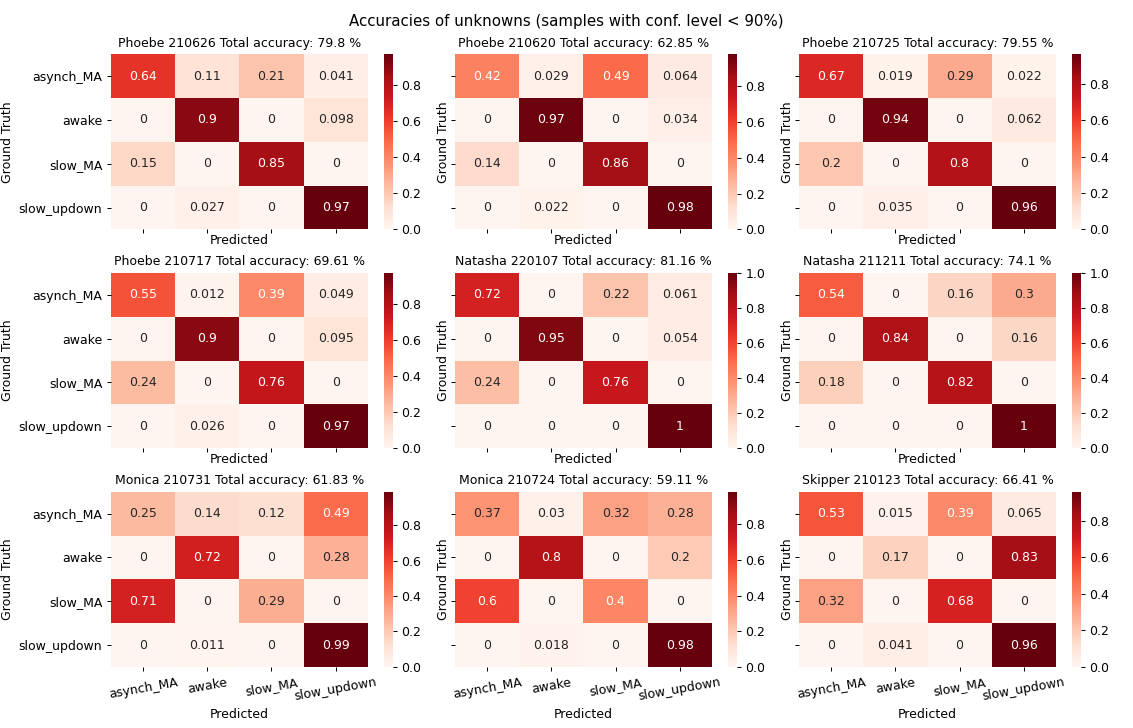

In [2]:
%matplotlib notebook
# define sessions to be included
name_times = ['Phoebe 210626', 'Phoebe 210620', 'Phoebe 210725', 'Phoebe 210717', 'Natasha 220107', 'Natasha 211211', 'Monica 210731', 'Monica 210724', 'Skipper 210123']

# define figure
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 9), sharex=True, sharey=True)
ax = ax.reshape(-1)
for ndx, name_time in enumerate(name_times):
    path = f'autoencoders/metadata_{"_".join(name_time.split(" "))}_withGT.pkl'
    with open(path, 'rb') as f:
        metadata=pickle.load(f)
        metadata_unknown = metadata.loc[metadata['labels']=='unknown']
    from sklearn.metrics import confusion_matrix
    labels = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown']
    # define arrays of labels for gt and predicted
    y_true = metadata_unknown['GT']
    y_pred = metadata_unknown['high_prob_state_label']
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # define total accuracy
    total_acc = np.sum(np.diag(cm)) / len(y_true)
    # Create a heatmap
    sns.heatmap(cm_normalized, annot=True, cmap="Reds", xticklabels=labels, yticklabels=labels, ax=ax[ndx])
    ax[ndx].set_title(f"{name_time } Total accuracy: {np.round(100*total_acc, 2)} %", fontsize=10)
    ax[ndx].set_xticklabels(labels, rotation=10)
    ax[ndx].set_xlabel("Predicted")
    ax[ndx].set_ylabel("Ground Truth")
fig.suptitle('Accuracies of unknowns (samples with conf. level < 90%)')
plt.tight_layout()


#### FINS AQUI

<IPython.core.display.Javascript object>


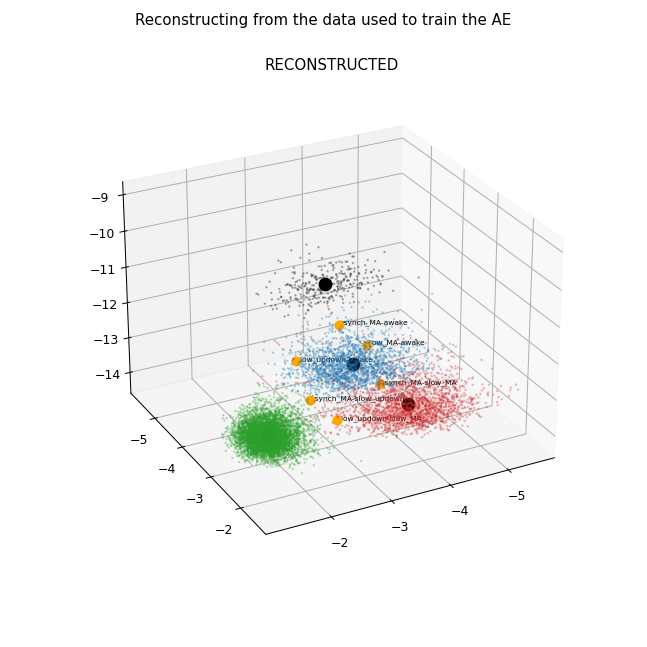

Text(0.5, 0.98, 'Reconstructing from the data used to train the AE')

In [4]:
colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 'half-state':'tab:orange', 'unknown': 'tab:brown', 'artifact':'gray'}
col_GT = [colors[label] for label in labels]
fig = plt.figure(figsize=(8, 8))
ax_re = fig.add_subplot(111, projection='3d')
ax_re.scatter(np.log(power_GT['reconstruct'][0, :]), np.log(power_GT['reconstruct'][1, :]), np.log(power_GT['reconstruct'][2, :]), c=col_GT, s=1, alpha=0.25)
# add centroids 
for label in set(labels):
    ax_re.scatter(centroids[label][0], centroids[label][1], centroids[label][2], marker='o', s=100, c='k')
# add mid points
unique_labels = list(set(labels))
for ldx0 in range(len(unique_labels)-1):
    for ldx1 in range(ldx0+1, len(unique_labels)):
        if f"{unique_labels[ldx0]}-{unique_labels[ldx1]}" in mid_points:
            comb = f"{unique_labels[ldx0]}-{unique_labels[ldx1]}"
        else:
            comb = f"{unique_labels[ldx1]}-{unique_labels[ldx0]}"
        ax_re.scatter(mid_points[comb][0],
                      mid_points[comb][1],
                      mid_points[comb][2], marker='o', s=50, c='orange')
        ax_re.text(mid_points[comb][0],
                   mid_points[comb][1],
                   mid_points[comb][2], f"{unique_labels[ldx0]}-{unique_labels[ldx1]}", fontsize=6)
ax_re.view_init(elev=20, azim=45)
ax_re.set_title('RECONSTRUCTED')
# ax_re.set_zlim([-17, -7])
fig.suptitle('Reconstructing from the data used to train the AE')

### Compare PCA original vs reconstruct
- With all good and bad classifications
- Each point must be coloured relative to its detected (GT or classif.) state

In [ ]:
from scipy.signal import welch as pwelch
colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 'unknown': 'tab:brown', 'artifact':'gray'}
col_original = [colors[min_mse_state_and_gt[i][1]] for i in min_mse_state_and_gt]
col_reconstructed = [colors[min_mse_state_and_gt[i][0]] for i in min_mse_state_and_gt]

custom_lines = [Line2D([0], [0], color=colors[state], lw=4) for state in colors.keys()]
custom_labels = [state for state in colors.keys()]

bands = [[0.1, 4], [4, 8], [100, 500]]
fxx_original, pxx_original = pwelch(x=waveforms_state_2d['unknown'], fs=1000, nfft=1000, nperseg=500, axis=1)
fxx_reconstruct, pxx_reconstruct = pwelch(x=reconstruct, fs=1000, nfft=1000, nperseg=500, axis=1)

# build band power
power = {'original': np.array([]), 'reconstruct': np.array([])}
for bdx, band in enumerate(bands):
    band_power = np.mean(pxx_original[:, ((fxx_original>=band[0])&(fxx_original<band[1]))], axis=1)
    power['original'] = np.vstack([power['original'], band_power]) if power['original'].size else band_power
    band_power = np.mean(pxx_reconstruct[:, ((fxx_reconstruct>=band[0])&(fxx_reconstruct<band[1]))], axis=1)
    power['reconstruct'] = np.vstack([power['reconstruct'], band_power]) if power['reconstruct'].size else band_power
    
fig = plt.figure(figsize=(16, 6))
ax_or = fig.add_subplot(131, projection='3d')
ax_re = fig.add_subplot(132, projection='3d')
ax_pred = fig.add_subplot(133, projection='3d')
ax_or.sharex(ax_re)
ax_or.sharey(ax_re)
ax_pred.sharex(ax_re)
ax_pred.sharey(ax_re)
ax_or.scatter(np.log(power['original'][0, :]), np.log(power['original'][1, :]), np.log(power['original'][2, :]), c=col_original, s=1)
ax_re.scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=col_original, s=1)
ax_pred.scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=col_reconstructed, s=2)

ax_or.view_init(elev=15, azim=45)
ax_re.view_init(elev=15, azim=45)
ax_pred.view_init(elev=15, azim=45)
ax_or.set_title('original samples\n labelled as GT')
ax_re.set_title('reconstructed samples\n labelled as GT')
ax_pred.set_title('reconstructed samples\n labelled as AE-predicted')
ax_re.set_zlim([-17, -7])
ax_or.set_zlim([-17, -7])
ax_pred.set_zlim([-17, -7])
ax_pred.legend(custom_lines, custom_labels)
plt.tight_layout()

## Centroid method
- Predict/Reconstruct each GT sample with the corresponding GT autoencoder
- Compute the band power for each reconstructed sample
- Compute the centroid of each state cluster
- Compute the mid points between each pair of clusters

In [ ]:
# from scipy.signal import welch as pwelch
# original_GT = np.array([])
# reconstruct_GT = np.array([])
# labels = []
# states_GT = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown']
# for state in states_GT:
#     print(state)
#     for i in range(waveforms_state_2d[state].shape[0]): # the samples assigned to each state are assigned via the AE classification
#         sample = waveforms_state_2d[state][i].reshape(1, -1) # Reshape the sample to have shape (1, n_features)
#         # Use the autoencoders to predict this sample
#         predicted = autoencoders[state].predict(sample, verbose=False)[0] # get the AE decision based ones
#         # vstack to original
#         original_GT = np.vstack([original_GT, sample]) if original_GT.size else sample
#         # vstack to reconstruct
#         reconstruct_GT = np.vstack([reconstruct_GT, predicted]) if reconstruct_GT.size else predicted
#     # append label
#     labels.extend([state] * waveforms_state_2d[state].shape[0])
    
# colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 'half-state':'tab:orange', 'unknown': 'tab:brown', 'artifact':'gray'}
# col_GT = [colors[label] for label in labels]
# bands = [[0.1, 4], [4, 8], [100, 500]]
# fxx_reconstruct_GT, pxx_reconstruct_GT = pwelch(x=reconstruct_GT, fs=1000, nfft=1000, nperseg=500, axis=1)

# # build band power
# power_GT = {'reconstruct': np.array([])}
# for bdx, band in enumerate(bands):
#     band_power_GT = np.mean(pxx_reconstruct_GT[:, ((fxx_reconstruct_GT>=band[0])&(fxx_reconstruct_GT<band[1]))], axis=1)
#     power_GT['reconstruct'] = np.vstack([power_GT['reconstruct'], band_power_GT]) if power_GT['reconstruct'].size else band_power_GT
    
# # define centroids
# centroids = {}
# # loop over labels
# for label in set(labels):
#     # find indices for each state
#     indices = np.where(np.array(labels)==label)[0]
#     # compute centroid
#     centroids[label] = np.array([
#         np.mean(np.log(power_GT['reconstruct'][0, indices])), 
#         np.mean(np.log(power_GT['reconstruct'][1, indices])), 
#         np.mean(np.log(power_GT['reconstruct'][2, indices]))])
    
# # define intermediate points
# mid_points = {}
# unique_labels = list(set(labels))
# for ldx0 in range(len(unique_labels)-1):
#     for ldx1 in range(ldx0+1, len(unique_labels)):
#         mid_points[f"{unique_labels[ldx0]}-{unique_labels[ldx1]}"] = [
#             (centroids[unique_labels[ldx0]][0] + centroids[unique_labels[ldx1]][0] ) / 2, 
#             (centroids[unique_labels[ldx0]][1] + centroids[unique_labels[ldx1]][1] ) / 2, 
#             (centroids[unique_labels[ldx0]][2] + centroids[unique_labels[ldx1]][2] ) / 2]

### Show reconstructed scatter plot

In [ ]:
colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 'half-state':'tab:orange', 'unknown': 'tab:brown', 'artifact':'gray'}
col_GT = [colors[label] for label in labels]
fig = plt.figure(figsize=(8, 8))
ax_re = fig.add_subplot(111, projection='3d')
ax_re.scatter(np.log(power_GT['reconstruct'][0, :]), np.log(power_GT['reconstruct'][1, :]), np.log(power_GT['reconstruct'][2, :]), c=col_GT, s=1, alpha=0.25)
# add centroids 
for label in set(labels):
    ax_re.scatter(centroids[label][0], centroids[label][1], centroids[label][2], marker='o', s=100, c='k')
# add mid points
unique_labels = list(set(labels))
for ldx0 in range(len(unique_labels)-1):
    for ldx1 in range(ldx0+1, len(unique_labels)):
        if f"{unique_labels[ldx0]}-{unique_labels[ldx1]}" in mid_points:
            comb = f"{unique_labels[ldx0]}-{unique_labels[ldx1]}"
        else:
            comb = f"{unique_labels[ldx1]}-{unique_labels[ldx0]}"
        ax_re.scatter(mid_points[comb][0],
                      mid_points[comb][1],
                      mid_points[comb][2], marker='o', s=50, c='orange')
        ax_re.text(mid_points[comb][0],
                   mid_points[comb][1],
                   mid_points[comb][2], f"{unique_labels[ldx0]}-{unique_labels[ldx1]}", fontsize=6)
ax_re.view_init(elev=20, azim=45)
ax_re.set_title('RECONSTRUCTED')
# ax_re.set_zlim([-17, -7])
fig.suptitle('Reconstructing from the data used to train the AE')

### Re-classify based on centroids
- If point is closed to either awake, slow_MA, asynch_MA, slow_updown or asynch_MA-slow_MA, it is classified as that
- Otherwise (falling into an intermediate point) it is classified as the GT state closer to the intermediate point

In [ ]:
imp.reload(fx)
centroid_points = np.array([])
centroid_labels =  []
for centroid_label, point in mid_points.items():
    centroid_points = np.vstack([centroid_points, np.array(point)]) if centroid_points.size else np.array(point)
    centroid_labels.append(centroid_label)
for centroid_label, point in centroids.items():
    centroid_points = np.vstack([centroid_points, np.array(point)]) 
    centroid_labels.append(centroid_label)

# classify all unknowns again based on centroids
labels_centroid_based = []
for i in range(power['reconstruct'].shape[1]):
    labels_centroid_based.append(fx.find_closest_centroid(np.log(power['reconstruct'][:, i]), centroid_points, centroid_labels))

In [ ]:
colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 
          'unknown': 'tab:brown', 'artifact':'gray', 'asynch_MA-slow_MA': 'tab:orange', 'slow_MA-asynch_MA': 'tab:orange'}
col_centroid = [colors[label] for label in labels_centroid_based]

fig = plt.figure(figsize=(10, 10))
ax_gt = fig.add_subplot(221, projection='3d')
ax_un_pred = fig.add_subplot(222, projection='3d')
ax_un_cent = fig.add_subplot(223, projection='3d')

for label in set(labels):
    ldx = np.where(np.array(labels)==label)[0]
    if label == 'slow_updown':
        ax_gt.scatter(np.log(power_GT['reconstruct'][0, ldx][::3]), np.log(power_GT['reconstruct'][1, ldx][::3]), np.log(power_GT['reconstruct'][2, ldx][::3]), c=colors[label], s=1, marker='.', alpha=0.2)
    elif label == 'awake':
        ax_gt.scatter(np.log(power_GT['reconstruct'][0, ldx]), np.log(power_GT['reconstruct'][1, ldx]), np.log(power_GT['reconstruct'][2, ldx]), c=colors[label], s=1, alpha=0.25)
    else:
        ax_gt.scatter(np.log(power_GT['reconstruct'][0, ldx]), np.log(power_GT['reconstruct'][1, ldx]), np.log(power_GT['reconstruct'][2, ldx]), c=colors[label], s=3, marker='.', alpha=0.2)
# add centroids 
for label in set(labels):
    ax_gt.scatter(centroids[label][0], centroids[label][1], centroids[label][2], edgecolor='k', marker='o', s=100, c=colors[label] if label != 'awake' else 'gray')

# add mid points
unique_labels = list(set(labels))
for ldx0 in range(len(unique_labels)-1):
    for ldx1 in range(ldx0+1, len(unique_labels)):
        if f"{unique_labels[ldx0]}-{unique_labels[ldx1]}" in mid_points:
            comb = f"{unique_labels[ldx0]}-{unique_labels[ldx1]}"
        else:
            comb = f"{unique_labels[ldx1]}-{unique_labels[ldx0]}"
        # only add the asynch_MA-slow_MA transition
        if comb == 'asynch_MA-slow_MA' or comb == 'slow_MA-asynch_MA':
            ax_gt.scatter(mid_points[comb][0],
                          mid_points[comb][1],
                          mid_points[comb][2], marker='o', s=50, edgecolor='k', c='orange')
#             ax_gt.text(mid_points[comb][0],
#                           mid_points[comb][1],
#                           mid_points[comb][2], f"{unique_labels[ldx0]}-{unique_labels[ldx1]}", fontsize=6)

        
ax_un_pred.scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=col_reconstructed, s=1)
ax_un_cent.scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=col_centroid, s=1)
 
ax_gt.view_init(elev=16, azim=54)
ax_gt.set_xlabel('Log Power in [0.1-4] Hz'); ax_gt.set_xlim([-5.5, -1]); ax_gt.set_xticks([-5, -4, -3, -2, -1])
ax_gt.set_ylabel('Log Power in [4-8] Hz'); ax_gt.set_ylim([-4.5, -1.5]); ax_gt.set_yticks([-4, -3, -2])
ax_gt.set_zlabel('Log Power in [100-500] Hz'); ax_gt.set_zticks([-10, -13, -16])
ax_un_pred.view_init(elev=16, azim=54)
ax_un_pred.set_xlabel('Log Power in [0.1-4] Hz'); ax_un_pred.set_xlim([-5.5, -1]); ax_un_pred.set_xticks([-5, -4, -3, -2, -1])
ax_un_pred.set_ylabel('Log Power in [4-8] Hz'); ax_un_pred.set_ylim([-4.5, -1.5]); ax_un_pred.set_yticks([-4, -3, -2])
ax_un_pred.set_zlabel('Log Power in [100-500] Hz'); ax_un_pred.set_zticks([-10, -13, -16])
ax_un_cent.view_init(elev=16, azim=54)
ax_un_cent.set_xlabel('Log Power in [0.1-4] Hz'); ax_un_cent.set_xlim([-5.5, -1]); ax_un_cent.set_xticks([-5, -4, -3, -2, -1])
ax_un_cent.set_ylabel('Log Power in [4-8] Hz'); ax_un_cent.set_ylim([-4.5, -1.5]); ax_un_cent.set_yticks([-4, -3, -2])
ax_un_cent.set_zlabel('Log Power in [100-500] Hz'); ax_un_cent.set_zticks([-10, -13, -16])
ax_gt.set_title('AE-RECONSTRUCTED SAMPLES (>90% THRESHOLD) \nFROM CNN MODEL CLASSIFICATION\n Coloured with the GT label', fontsize=10)
ax_un_pred.set_title('AE-RECONSTRUCTED SAMPLES (<90%THRESHOLD) \nFROM AE [min(MSE)] CLASSIFICATION\n Coloured with the AE classification label', fontsize=10)
ax_un_cent.set_title('AE-RECONSTRUCTED SAMPLES (<90%THRESHOLD) \nFROM AE [min(MSE)] CLASSIFICATION\n Coloured with the centroid-based classification', fontsize=10)
cols_legend = ['awake', 'slow_updown', 'slow_MA', 'asynch_MA', 'asynch_MA-slow_MA']
cols_legend_AE = ['awake', 'slow_updown', 'slow_MA', 'asynch_MA', 'unknown']
custom_lines = [Line2D([0], [0], color=colors[state], lw=4) for state in cols_legend]
custom_lines_AE = [Line2D([0], [0], color=colors[state], lw=4) for state in cols_legend_AE]
custom_labels = [state for state in cols_legend]
custom_labels_AE = [state for state in cols_legend_AE]
ax_gt.legend(custom_lines, custom_labels, fontsize=6)
ax_un_pred.legend(custom_lines_AE, custom_labels_AE, fontsize=6)
ax_un_cent.legend(custom_lines, custom_labels, fontsize=6)
# ax_re.set_zlim([-17, -7])
ax_gt.xaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_gt.yaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_gt.zaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_un_pred.xaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_un_pred.yaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_un_pred.zaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_un_cent.xaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_un_cent.yaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
ax_un_cent.zaxis._axinfo['grid'].update({'linewidth': 0.25, 'color': (0, 0, 0, 0.5), 'linestyle': '--'})
plt.tight_layout()

### Figure 3 Reconstructed GT

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14, 8), sharex=True, sharey=True)
states_GT = ['awake', 'slow_updown', 'slow_MA', 'asynch_MA']
dict_frames = {'asynch_MA': 'tab:blue', 'awake': 'k', 'slow_MA': 'tab:red', 'slow_updown': 'tab:green'}
names_states = {'asynch_MA': 'asynch-MA', 'awake': 'AW', 'slow_MA': 'slow-MA', 'slow_updown': 'SO'}
id_state = {'asynch_MA': 4, 'awake': 2, 'slow_MA': 2, 'slow_updown': 2100}
for s0, state in enumerate(states_GT):
    sample = waveforms_state_2d[state][id_state[state], :].reshape(1, -1)
    ax[s0, 0].plot(sample[0], c='k')
    ax[s0, 0].set_title(f"GT: {names_states[state]}")
    ax[s0, 0].spines[['bottom', 'top', 'right', 'left']].set_color(dict_frames[state])
    ax[s0, 0].spines[['bottom', 'top', 'right', 'left']].set_linewidth(4)
    for s1, state_AE in enumerate(states_GT):
        # Use the autoencoders to predict this sample
        predicted = autoencoders[state_AE].predict(sample, verbose=False)[0] # get the AE decision based ones
        ax[s0, s1+1].plot(predicted, c='k')
        ax[s0, s1+1].set_title(f"AE: {names_states[state_AE]} ")
        ax[s0, s1+1].spines[['bottom', 'top', 'right', 'left']].set_color(dict_frames[state_AE])
        ax[s0, s1+1].set_xticks([])
        ax[s0, s1+1].set_yticks([])
        if s0 == s1:
            ax[s0, s1+1].spines[['bottom', 'top', 'right', 'left']].set_linewidth(4)

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\AE_reconstruction.svg', dpi=600)

In [ ]:
match_centroids_GT = 0
match_centroids_AE = 0

for i in range(power['reconstruct'].shape[1]):
    if min_mse_state_and_gt[i][1] == labels_centroid_based[i]:
        match_centroids_GT += 1
    if min_mse_state_and_gt[i][0] == labels_centroid_based[i]:
        match_centroids_AE += 1
print(f"GT: {match_centroids_GT / power['reconstruct'].shape[1]}")
print(f"AE: {match_centroids_AE / power['reconstruct'].shape[1]}")

In [ ]:
ax_gt._get_view()

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(16, 5))
for sdx, state in enumerate(set(labels_centroid_based)):
    tdx = np.random.choice(np.where(np.array(labels_centroid_based)==state)[0], 20)
    for idx, i in enumerate(tdx):
        if min_mse_state_and_gt[i][1] == state:
            ax[sdx].plot(idx*5 + waveforms_state_2d['unknown'][i, :], c=colors[state])
        else:
            ax[sdx].plot(idx*5 + waveforms_state_2d['unknown'][i, :], c=colors[min_mse_state_and_gt[i][1]])
    ax[sdx].set_title(f'{state}', fontsize=8, color=colors[state])
plt.tight_layout()

In [ ]:
accuracies = {}
accuracies['Phoebe_210626'] = {'GT': 0.76, 'AE': 0.43}
accuracies['Phoebe_210620'] = {'GT': 0.72, 'AE': 0.42}
accuracies['Phoebe_210725'] = {'GT': 0.73, 'AE': 0.38}
accuracies['Phoebe_210717'] = {'GT': 0.72, 'AE': 0.43}
accuracies['Natasha_220107'] = {'GT': 0.49, 'AE': 0.29}
accuracies['Natasha_211211'] = {'GT': 0.68, 'AE': 0.42}
accuracies['Monica_210731'] = {'GT': 0.55, 'AE': 0.30}
accuracies['Monica_210724'] = {'GT': 0.27, 'AE': 0.32}
accuracies['Skipper_210123'] = {'GT': 0.62, 'AE': 0.24} 
df_acc = pd.DataFrame(columns=['sub', 'cond', 'value'])
for sub in accuracies.keys():
    for key in accuracies[sub].keys():
        df_acc = pd.concat([df_acc, pd.DataFrame({
            'sub':sub, 
            'cond':key, 
            'value':[accuracies[sub][key]],
        })], ignore_index=True)
        
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=df_acc, x='sub', y='value', hue='cond', hue_order=['AE','GT'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=8)
ax.set_xlabel('Subject')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of unknowns classified using the centroid-based labelling when compared to AutoEncoders [AE] prediction vs Ground-Truth [GT]', fontsize=10)
plt.tight_layout()

In [ ]:
name_times = ['Phoebe 210626', 'Phoebe 210620', 'Phoebe 210725', 'Phoebe 210717', 'Natasha 220107', 'Natasha 211211', 'Monica 210731', 'Monica 210724', 'Skipper 210123']
df_counts = pd.DataFrame(columns=['sub', 'state', 'count'])
for name_time in name_times:
    with open(f'C:/Users/manasanch.IBP10386/Desktop/ANESTHESIA_LEVELS/DATA/DATA_LIVEPAPER/RAW TRANSITIONS/full_recordings/autoencoders/reconstruct_{name_time}' , 'rb') as f:
        info = pickle.load(f)
    min_mse_state_and_gt = info['min_mse_state_and_gt']
    clear_output()
    unique_states, counts = np.unique([min_mse_state_and_gt[i][0] for i in range(len(min_mse_state_and_gt))], return_counts=True)
    for udx in range(len(unique_states)):
        df_counts = pd.concat([df_counts, pd.DataFrame({
            'sub': name_time, 
            'state': unique_states[udx], 
            'count': [counts[udx]],
        })], ignore_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.barplot(data=df_counts, x='sub', y='count', hue='state', hue_order=['unknown', 'artifact', 'asynch_MA', 'awake', 'slow_MA', 'slow_updown'], ax=ax)
ax.legend(fontsize=8)
ax.set_ylabel('Counts')
ax.set_xlabel('Subject')
ax.set_title('Counts for each state as predicted from the AE (state with min MSE)')

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 6))
sns.countplot(data=gui.df_half, x='value', ax=ax[0])
ax[0].set_xticklabels(['Good Half-State', 'Bad Half-State'])
ax[0].set_title('Proportion of well detected half-states (n=150)')

indices_good = np.random.choice([i for i in range(len(gui.df_half)) if gui.df_half['value'].iloc[i] == 'Good'], 10)
for idx, i in enumerate(indices_good):
    ax[1].plot(idx*5 + gui.df_half['original'].iloc[i], c='k')

indices_bad = np.random.choice([i for i in range(len(gui.df_half)) if gui.df_half['value'].iloc[i] == 'False'], 10)
for idx, i in enumerate(indices_bad):
    ax[2].plot(idx*5 + gui.df_half['original'].iloc[i], c='k')
ax[1].set_title('Good Half-State')
ax[2].set_title('Bad Half-State')
plt.tight_layout()
plt.savefig(f'C:\\Users\\manasanch.IBP10386\\Desktop\\ANESTHESIA_LEVELS\\DATA\\DATA_LIVEPAPER\\RAW TRANSITIONS\\full_recordings\\autoencoders\\metrics_halfstates_{name_time}.png')

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(8, 6))

# Example ground truth and predicted values as strings
y_true = [min_mse_state_and_gt[i][1] for i in range(len(min_mse_state_and_gt))]

# Create a pandas DataFrame to easily work with labels
labels = sorted(list(set(y_true).union(set(labels_centroid_based))))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, labels_centroid_based, labels=labels)

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels, ax=ax)

# Add labels
ax.set_xlabel("Centroid-predicted")
ax.set_ylabel("Ground Truth")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, fontsize=8)
ax.set_title('Confusion Matrix for GT vs Centroid-based detection')
plt.tight_layout()

In [ ]:
set(labels_centroid_based)

In [ ]:
reconstruct_test = {state: np.array([]) for state in autoencoders.keys()}
for i in range(waveforms_state_2d['unknown'].shape[0]):
    if not i % 100:
        print(i)
    sample = waveforms_state_2d['unknown'][i].reshape(1, -1)  # Reshape the sample to have shape (1, n_features)
    for state in autoencoders.keys():
        # Use the autoencoders to predict this sample
        predicted = autoencoders[state].predict(sample, verbose=False)[0] # get the AE decision based ones
        # vstack
        reconstruct_test[state] = np.vstack([reconstruct_test[state], predicted]) if reconstruct_test[state].size else predicted

In [ ]:
# build band power
power_all = {state: np.array([]) for state in autoencoders.keys()}
# loop over states
for state in autoencoders.keys():
    # compute psd
    fxx_all, pxx_all = pwelch(x=reconstruct_test[state], fs=1000, nfft=1000, nperseg=500, axis=1)
    for bdx, band in enumerate(bands):
        band_power = np.mean(pxx_all[:, ((fxx_all>=band[0])&(fxx_all<band[1]))], axis=1)
        power_all[state] = np.vstack([power_all[state], band_power]) if power_all[state].size else band_power

In [ ]:
col_all = [colors[min_mse_state_and_gt[i][1]] for i in min_mse_state_and_gt]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 8), subplot_kw={'projection': '3d'})
ax = ax.reshape(-1)
for sdx, state in enumerate(autoencoders.keys()):
    ax[sdx].scatter(np.log(power_all[state][0, :]), np.log(power_all[state][1, :]), np.log(power_all[state][2, :]), c=col_all, s=1)
    ax[sdx].set_title(f'Reconstructed with AE {state}', fontsize=12)
    ax[sdx].set_xlim([-6, -1])
    ax[sdx].set_ylim([-6, -2])
    ax[sdx].set_zlim([-16, -10])

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(16, 6), sharex=True, sharey=True)
for sdx, state in enumerate(autoencoders.keys()):
    for i in range(10):
        ax[sdx].plot(i*3 + reconstruct_test[state][i, :], c='k')
    ax[sdx].set_title(f'Reconstructed with AE {state}', fontsize=8)

In [ ]:
# get random indices for match
indices_bad = [i for i in range(len(min_mse_state_and_gt)) if min_mse_state_and_gt[i][0]=='artifact']
selected = np.random.choice(indices_bad, 10)
fig, ax = plt.subplots(ncols=2, figsize=(10, 8), sharey=True, sharex=True)
for sdx, sel in enumerate(selected):
    ax[0].plot(sdx*5 + waveforms_state_2d['unknown'][sel], c=colors[min_mse_state_and_gt[sel][1]])
    ax[1].plot(sdx*5 + reconstruct[sel, :], c=colors[min_mse_state_and_gt[sel][0]])
    ax[0].text(-550, sdx*5, min_mse_state_and_gt[sel][1], fontsize=8)
    ax[1].text(-500, sdx*5, min_mse_state_and_gt[sel][0], fontsize=8)


ax[0].set_yticks([])
ax[0].set_title('ORIGINAL')
ax[1].set_title('ARTIFACT')
plt.savefig('C:\\Users\\manasanch.IBP10386\\Desktop\\ANESTHESIA_LEVELS\\DATA\\DATA_LIVEPAPER\\RAW TRANSITIONS\\full_recordings\\autoencoders\\orig_vs_reconstruct_artifact.png')

In [ ]:
colors = {'awake': 'k', 'slow_updown': 'tab:green', 'slow_MA': 'tab:red', 'asynch_MA':'tab:blue', 'half-state':'tab:orange'}
# get random indices for match
indices_half = [i for i in range(len(min_mse_state_and_gt)) if min_mse_state_and_gt[i][0]=='half-state']
# indices_half = np.random.choice(indices_half, 150)
indices_half = [1314,   91, 1230,  418,  423,  368,  583,  764, 1148,  913,  160, 391, 1171, 1240, 1030,  144,  539,  295,  538, 1162,  307,  364, 188,  774,  624,  220,  233, 1138, 1126,  672,  253, 1303,  491, 744,   74,   40, 1280, 1309, 1240,  810,  317,  653,  302,  206,  95,  741, 1158,  799,  702,  475, 1170,  380,  284,  534, 1071,1193, 1218,  616,  779,  919,  902,   22,  158,   31,  128,  788,1231,  604, 1084,  842,   31,  971,  796,  902,  480,  241,  172, 534, 1179,  723,  167,  902,  125,  253,  253, 1235,  724, 1094, 469,  391,  503,  219,  501,  279, 1193,  284,  338,  365,   24, 779, 1255,  326,  168, 1097,  719,  982,  422, 1112, 1305, 1070, 881, 1071,  624,  299,  218, 1040,  463,  358,  359,  176, 1158, 266,  613, 1112,  632,  375, 1151,  211,  128,  203,  475,  674, 257,  222,  369,  261,  982,  964,  191,   52,  385, 1086,  966, 714, 1221, 1162,  486, 1083,  192, 1047]selected = np.random.choice(indices_half, 10)
fig, ax = plt.subplots(ncols=2, figsize=(10, 8), sharey=True, sharex=True)
for sdx, sel in enumerate(selected):
    ax[0].plot(sdx*5 + waveforms_state_2d['unknown'][sel], c=colors[min_mse_state_and_gt[sel][1]])
    ax[1].plot(sdx*5 + reconstruct[sel, :], c=colors[min_mse_state_and_gt[sel][0]])
    ax[0].text(-550, sdx*5, min_mse_state_and_gt[sel][1], fontsize=8)

    
